In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from src.train import train, test
from src.models import Simple3BlockCNN, SimpleResNetCNN, BNDropout3BlockCNN, AIDetectorResNet
from src.utils import split_data, print_history

Using device: mps


# Poster Detection

In [2]:
BATCH_SIZE = 32
TRAIN_SIZE = 0.8
EPOCHS = 50
LEARNING_RATE = 1e-3
PATIENCE = 10

train_loader, val_loader, test_loader = split_data(root_dir="data/poster-detect", batch_size=BATCH_SIZE)

           Train    Val    Test
-------  -------  -----  ------
Samples     8000   1000    1000
Batches      250     32      32


## Training

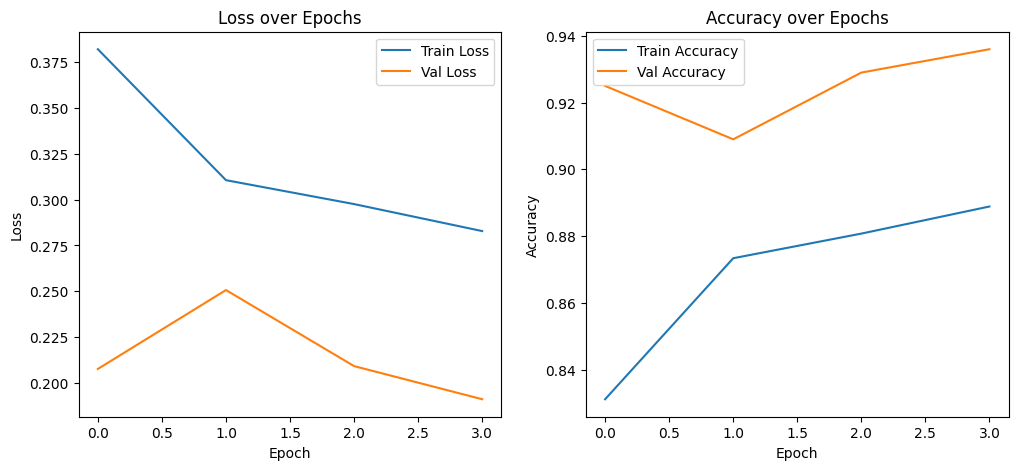

Epoch 4/50
  Train Loss: 0.2828, Train Acc: 0.8889
  Val   Loss: 0.1911, Val   Acc: 0.9360
  Best Val Acc: 0.9360 at Epoch 4
  Learning Rate: 0.001000


KeyboardInterrupt: 

In [3]:
# model = Simple3BlockCNN()
model = SimpleResNetCNN()
# model = BNDropout3BlockCNN()

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)

history = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=EPOCHS,
    patience=PATIENCE
)

In [4]:
history_path = "models/SimpleResNetCNN/run_1/history.json"
print_history(history_path)

Epoch      Train Loss    Val Loss    Train Acc    Val Acc
-------  ------------  ----------  -----------  ---------
1              0.3642      0.2271       0.8404      0.908
2              0.298       0.1992       0.8825      0.932
3              0.2873      0.2142       0.8838      0.91
4              0.2967      0.1972       0.8765      0.921
5*             0.2792      0.1837       0.8855      0.944
6              0.2592      0.1942       0.8939      0.928
7              0.275       0.1787       0.8889      0.941
8              0.2562      0.2402       0.8989      0.9
9              0.2711      0.2244       0.8894      0.912
10             0.2502      0.1751       0.9038      0.935

Best val acc: 0.9440 (Epoch 5)
Saved model: models/SimpleResNetCNN/run_1/best_model.pth


## Testing

In [7]:
simple_model = Simple3BlockCNN()
simple_model_path = "models/Simple3BlockCNN/run_3/best_model.pth"
simple_model.load_state_dict(torch.load(simple_model_path))

resnet_model = SimpleResNetCNN()
resnet_model_path = "models/SimpleResNetCNN/run_1/best_model.pth"
resnet_model.load_state_dict(torch.load(resnet_model_path))

criterion = nn.BCEWithLogitsLoss()

In [8]:
simple_test = test(model=simple_model,
                   test_loader=test_loader,
                   criterion=criterion)

resnet_test = test(model=resnet_model,
                     test_loader=test_loader,
                     criterion=criterion)

Testing:   0%|          | 0/32 [00:00<?, ?it/s]

In [9]:
from tabulate import tabulate

table_data = [
    ["Simple3BlockCNN", round(simple_test[0], 3), simple_test[1]],
    ["SimpleResNetCNN", round(resnet_test[0], 3), resnet_test[1]],
]

headers = ["Model", "Loss", "Accuracy"]

print(tabulate(table_data, headers=headers))


Model              Loss    Accuracy
---------------  ------  ----------
Simple3BlockCNN   0.316       0.872
SimpleResNetCNN   0.187       0.935
